In [31]:
import psycopg2
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
import matplotlib
import warnings
import yellowbrick as yb

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier

from yellowbrick.classifier import ClassificationReport

warnings.simplefilter(action='ignore', category=FutureWarning)

In [32]:
conn = psycopg2.connect( 
                        host = 'project.cgxhdwn5zb5t.us-east-1.rds.amazonaws.com',
                        port = 5432, 
                        user = 'postgres',
                        password = 'Admin123',
                        database = 'postgres')
cursor = conn.cursor()

In [33]:
DEC2FLOAT = psycopg2.extensions.new_type(
    psycopg2.extensions.DECIMAL.values,
    'DEC2FLOAT',
    lambda value, curs: float(value) if value is not None else None)
psycopg2.extensions.register_type(DEC2FLOAT)

In [34]:
cursor.execute('Select * from "ahshouseholdclass2"')
rows = cursor.fetchall()
col_names = []
for elt in cursor.description:
    col_names.append(elt[0])

df = pd.DataFrame(data=rows, columns=col_names )

In [35]:
df.columns

Index(['index', 'CONTROL', 'YEAR', 'RATINGHS_BIN', 'BEDROOMS', 'STORIES',
       'PERPOVLVL', 'HHADLTKIDS', 'HINCP', 'UNITSIZE', 'NUMVETS', 'LOTSIZE',
       'UFINROOMS', 'HHAGE', 'PARTNER', 'OTHERAMT', 'KITCHENS', 'NUMSECFAM',
       'OILAMT', 'DINING', 'FINCP', 'NUMELDERS', 'WATERAMT', 'GASAMT',
       'TOTROOMS', 'HHYNGKIDS', 'NUMSUBFAM', 'BATHROOMS', 'NUMYNGKIDS',
       'TRASHAMT', 'NUMOLDKIDS', 'NUMNONREL', 'NUMPEOPLE', 'HHMOVE', 'UTILAMT',
       'ELECAMT', 'NUMADULTS', 'MULTIGEN', 'LAUNDY', 'HHOLDKIDS', 'FINROOMS',
       'LN_HINCP', 'LN_FINCP', 'HINCP_BIN', 'FINCP_BIN', 'NUMCARE', 'NUMWALK',
       'HHRACE', 'OMB13CBSA', 'HSHLDTYPE', 'MVG3COST', 'MVG2COST', 'MILHH',
       'HHMAR', 'HHNATVTY', 'COOKFUEL', 'NUMMEMRY', 'NUMERRND', 'NUMSEE',
       'BLD', 'NUMHEAR', 'MVG1COST', 'DIVISION', 'FIREPLACE', 'CONDO',
       'OWNLOT', 'FRIDGE', 'FIRSTHOME', 'HHCARE', 'NOSTEP', 'WASHER', 'HHSEE',
       'KITCHSINK', 'HHERRND', 'WINBARS', 'HHWALK', 'HHHEAR', 'HHSEX',
       'HHMEMRY', 'GA

In [36]:
df['HINCP_BIN'].value_counts()


(40000.0, 50000.0]     2465
(30000.0, 40000.0]     2409
(20000.0, 30000.0]     2403
(50000.0, 60000.0]     2220
(60000.0, 70000.0]     2011
(10000.0, 20000.0]     2003
(70000.0, 80000.0]     1956
(80000.0, 90000.0]     1737
(90000.0, 100000.0]    1558
(0.0, 10000.0]         1346
Name: HINCP_BIN, dtype: int64

In [37]:
df['RATINGHS_BIN'].value_counts()


extremely satisfied    7021
satisfied              5284
not satisfied          4887
very satisfied         2916
Name: RATINGHS_BIN, dtype: int64

In [38]:
df.head(10)

,index,CONTROL,YEAR,RATINGHS_BIN,BEDROOMS,STORIES,PERPOVLVL,HHADLTKIDS,HINCP,UNITSIZE,...,HHSEE,KITCHSINK,HHERRND,WINBARS,HHWALK,HHHEAR,HHSEX,HHMEMRY,GARAGE,DISHWASH
0,0,11000006,2017,extremely satisfied,3.0,1.0,361.0,0.0,58700.0,4.0,...,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0
1,1,11000023,2017,satisfied,3.0,3.0,501.0,0.0,100000.0,4.0,...,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0
2,2,11000046,2017,extremely satisfied,3.0,1.0,52.0,0.0,15000.0,2.0,...,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0
3,3,11000048,2017,very satisfied,4.0,3.0,406.0,0.0,100000.0,6.0,...,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0
4,4,11000052,2017,not satisfied,4.0,2.0,113.0,0.0,13200.0,3.0,...,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0
5,5,11000054,2017,satisfied,2.0,7.0,501.0,0.0,71004.0,3.0,...,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0
6,6,11000062,2017,not satisfied,2.0,1.0,104.0,0.0,30200.0,4.0,...,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0
7,7,11000066,2017,not satisfied,2.0,1.0,117.0,1.0,29000.0,3.0,...,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
8,8,11000067,2017,satisfied,2.0,1.0,198.0,0.0,25000.0,3.0,...,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
9,9,11000079,2017,satisfied,2.0,2.0,302.0,0.0,59000.0,5.0,...,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0


In [39]:
LABEL_MAP = {
"(90000.0, 100000.0]": 10,
"(80000.0, 90000.0]": 9,
"(70000.0, 80000.0]": 8,   
"(60000.0, 70000.0]": 7,
"(50000.0, 60000.0]": 6,
"(40000.0, 50000.0]": 5,
"(30000.0, 40000.0]": 4,
"(20000.0, 30000.0]": 3,
"(10000.0, 20000.0]": 2,
"(0.0, 10000.0]": 1}

# Convert categorical labels into incremental value
df['HINCP_BIN'] = df['HINCP_BIN'].map(LABEL_MAP).to_frame()

### Class Balanced

In [42]:
# Create the train and test data
from sklearn.model_selection import train_test_split

#X = df[[
    #'PERPOVLVL','NUMELDERS',  #'ELECAMT',#'UTILAMT', 'DIVISION',#'HHNATVTY', 
        #'BEDROOMS','OMB13CBSA','BATHROOMS', 'HHMOVE','UNITSIZE', 'HINCP_BIN',
        #'HHWALK', 'HHHEAR', 'LAUNDY'
        #'HHSEX','GARAGE', 'DISHWASH','DINING']]
X = df[['HHAGE','HHMOVE','UTILAMT','PERPOVLVL','HINCP','LN_HINCP','FINCP','LN_FINCP','ELECAMT','WATERAMT','TRASHAMT', 'GASAMT' ]]
y = df['RATINGHS_BIN']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

In [43]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 33)

In [44]:
X_sm, y_sm = sm.fit_sample(X, y)


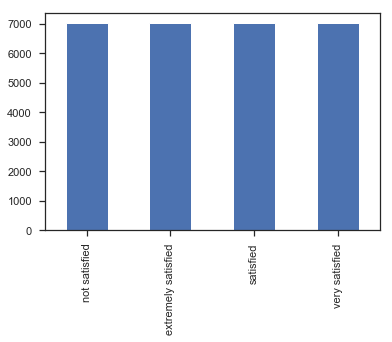

In [45]:
X_sm, y_sm = sm.fit_sample(X_sm, y_sm.ravel())
pd.Series(y_sm).value_counts().plot.bar()

In [46]:
def score_model(X, y, estimator, **kwargs):

    y = LabelEncoder().fit_transform(y)

    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')), 
         ('estimator', estimator)
    ])

    model.fit(X_train, y_train, **kwargs)  
    
    expected  = y_test
    predicted = model.predict(X_test)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted, average='micro')))

In [47]:
models = [
    SVC(), NuSVC(), LinearSVC(), 
    SGDClassifier(), KNeighborsClassifier(), 
    LogisticRegression(), 
    #aggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100),
    GradientBoostingClassifier(n_estimators=100,learning_rate=.3)
    #learning_rate=.5,max_depth=4, min_samples_leaf=75
]

for model in models:
    score_model(X_sm, y_sm, model)

SVC: 0.3610144206862258
NuSVC: 0.3314271506713078
LinearSVC: 0.3167578319244157
SGDClassifier: 0.3274490303331676
KNeighborsClassifier: 0.299602187966186


/Users/lisahuynh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression: 0.32148184982595723
ExtraTreesClassifier: 0.3530581800099453
RandomForestClassifier: 0.3453505718547986
GradientBoostingClassifier: 0.33938339134758827


In [30]:
models = [
    SVC(), NuSVC(), LinearSVC(), 
    SGDClassifier(), KNeighborsClassifier(), 
    LogisticRegression(), 
    #aggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100),
    GradientBoostingClassifier(n_estimators=100,learning_rate=.3)
    #learning_rate=.5,max_depth=4, min_samples_leaf=75
]

for model in models:
    score_model(X_train, y_train, model)

SVC: 0.38587767279960217
NuSVC: 0.3508204873197414
LinearSVC: 0.3814022874191944
SGDClassifier: 0.34783689706613624
KNeighborsClassifier: 0.3356539035305818


/Users/lisahuynh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression: 0.3823968175037295
ExtraTreesClassifier: 0.3538040775733466
RandomForestClassifier: 0.3639980109398309
GradientBoostingClassifier: 0.3712083540527101


## RandomSearch Cross Validation

In [ ]:
#current parameters used
RandomForestClassifier().get_params()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)


### Random Hyperparameter Grid

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

### Random Search Training

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifer()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
#best parameters from fitting the random search
rf_random.best_params_

### Evaluate Random Search

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train, Y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

## GridSearch Cross Validation

In [16]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [17]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': ['auto','sqrt', 'log2'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [20]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
/Users/lisahuynh/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.3min
/Users/lisahuynh/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/lisahuynh/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker

KeyboardInterrupt: 

In [19]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_


best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_labels)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))


Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

## Classification Reports

### SVC

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

#train the model on train set 
model = SVC() 
model.fit(X_train, y_train) 
  
# print prediction results 
predictions = model.predict(X_test) 
print(classification_report(y_test, predictions)) 

### RandomForestClassifer

In [21]:
#random plug and chug parameters

from sklearn.metrics import classification_report, confusion_matrix

#train the model on train set 
model = RandomForestClassifier(bootstrap=True, max_features='sqrt', 
                               criterion='entropy',n_estimators=500, 
                               random_state=33, min_samples_leaf=4, min_samples_split=5)
model.fit(X_train, y_train) 
  
# print prediction results 
predictions = model.predict(X_test) 
print(classification_report(y_test, predictions)) 

                     precision    recall  f1-score   support

extremely satisfied       0.42      0.72      0.53      1390
      not satisfied       0.41      0.34      0.37      1010
          satisfied       0.33      0.24      0.28      1062
     very satisfied       0.20      0.01      0.01       560

           accuracy                           0.40      4022
          macro avg       0.34      0.33      0.30      4022
       weighted avg       0.36      0.40      0.35      4022



In [34]:
#from gridsearch - best parameters

from sklearn.metrics import classification_report, confusion_matrix

#train the model on train set 
model = RandomForestClassifier(bootstrap=True, max_features='auto', 
                               criterion='gini',n_estimators=200, 
                               random_state=42, min_samples_leaf=4, warm_start=False)
model.fit(X_train, y_train) 
  
# print prediction results 
predictions = model.predict(X_test) 
print(classification_report(y_test, predictions)) 

                     precision    recall  f1-score   support

extremely satisfied       0.43      0.72      0.53      1390
      not satisfied       0.41      0.33      0.37      1010
          satisfied       0.33      0.26      0.29      1062
     very satisfied       0.25      0.01      0.01       560

           accuracy                           0.40      4022
          macro avg       0.35      0.33      0.30      4022
       weighted avg       0.37      0.40      0.36      4022



In [21]:
#from random search - best parameters

from sklearn.metrics import classification_report, confusion_matrix

#train the model on train set 
model = RandomForestClassifier(bootstrap=True, max_features= 'sqrt', 
                               max_depth=10, n_estimators=200,
                               min_samples_leaf=2,
                               min_samples_split= 5)
model.fit(X_train, y_train) 
  
# print prediction results 
predictions = model.predict(X_test) 
print(classification_report(y_test, predictions)) 


                     precision    recall  f1-score   support

extremely satisfied       0.41      0.74      0.53      1410
      not satisfied       0.37      0.31      0.34       987
          satisfied       0.31      0.20      0.24      1021
     very satisfied       0.00      0.00      0.00       604

           accuracy                           0.39      4022
          macro avg       0.27      0.31      0.28      4022
       weighted avg       0.31      0.39      0.33      4022



/Users/lisahuynh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lisahuynh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lisahuynh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:

from sklearn.metrics import classification_report, confusion_matrix

#train the model on train set 
model = RandomForestClassifier(bootstrap=True, max_features= 'sqrt', 
                               max_depth=200, n_estimators=500,
                               min_samples_leaf=2,
                               min_samples_split= 10)
model.fit(X_train, y_train) 
  
# print prediction results 
predictions = model.predict(X_test) 
print(classification_report(y_test, predictions)) 

                     precision    recall  f1-score   support

extremely satisfied       0.42      0.69      0.52      1410
      not satisfied       0.39      0.33      0.35       987
          satisfied       0.30      0.24      0.27      1021
     very satisfied       0.25      0.01      0.02       604

           accuracy                           0.39      4022
          macro avg       0.34      0.32      0.29      4022
       weighted avg       0.35      0.39      0.34      4022



### GradientBoostingClassifier

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

#train the model on train set 
model = GradientBoostingClassifier() 
model.fit(X_train, y_train) 
  
# print prediction results 
predictions = model.predict(X_test) 
print(classification_report(y_test, predictions)) 

### ExtraTreesClassifier

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

#train the model on train set 
model = ExtraTreesClassifier() 
model.fit(X_train, y_train) 
  
# print prediction results 
predictions = model.predict(X_test) 
print(classification_report(y_test, predictions)) 